In [27]:
import pandas as pd
import random
import matplotlib.pyplot as plt

# ===== User Input =====
max_level = int(input("Enter maximum upgrade level: "))

# Input success rate for each level in %
success_rates = []
for i in range(1, max_level + 1):
    rate = float(input(f"Enter success rate for level {i} in %: "))
    success_rates.append(rate / 100)  # Convert to 0~1

# Failure mode selection
print("\n[Failure Mode Options]")
print("A: Keep current level on failure")
print("B: Decrease by one level on failure")
print("C: Reset to level 0 on failure")
fail_mode = input("Select failure mode (A/B/C): ").upper()


# Simulation count
n_simulations = int(input("Enter number of simulations: "))

Enter maximum upgrade level:  9
Enter success rate for level 1 in %:  50
Enter success rate for level 2 in %:  50
Enter success rate for level 3 in %:  50
Enter success rate for level 4 in %:  13.5
Enter success rate for level 5 in %:  6.5
Enter success rate for level 6 in %:  5.5
Enter success rate for level 7 in %:  4.5
Enter success rate for level 8 in %:  4
Enter success rate for level 9 in %:  3.5



[Failure Mode Options]
A: Keep current level on failure
B: Decrease by one level on failure
C: Reset to level 0 on failure


Select failure mode (A/B/C):  A
Enter number of simulations:  500


In [28]:
# ===== Simulation =====
results = []
level_progress = {i: [] for i in range(1, max_level + 1)}

for trial in range(1, n_simulations + 1):
    current_level = 0
    attempts = 0
    step_count = [0] * (max_level + 1)

    while current_level < max_level:
        attempts += 1
        step_count[current_level] += 1

        if random.random() < success_rates[current_level]:  # Success
            current_level += 1
        else:  # Failure handling
            if fail_mode == 'B' and current_level > 0:
                current_level -= 1
            elif fail_mode == 'C':
                current_level = 0

    # Store per-level attempts
    for i in range(1, max_level + 1):
        level_progress[i].append(step_count[i - 1])

    results.append({
        "Simulation_No": trial,
        "Total_Attempts": attempts
    })

In [29]:
# ===== Convert to DataFrame =====
df_result = pd.DataFrame(results)
avg_steps = {level: sum(times) / len(times) for level, times in level_progress.items()}
df_level = pd.DataFrame(list(avg_steps.items()), columns=["Upgrade_Level", "Avg_Attempts"])

# ===== Display DataFrames =====
print("\n===== ITEM UPGRADE SIMULATION RESULT =====")
print(df_result)
print("\n===== AVERAGE ATTEMPTS PER LEVEL =====")
print(df_level)
print("\nOverall Average Attempts:", round(df_result["Total_Attempts"].mean(), 2))
print("Standard Deviation:", round(df_result["Total_Attempts"].std(), 2))


===== ITEM UPGRADE SIMULATION RESULT =====
     Simulation_No  Total_Attempts
0                1             119
1                2             131
2                3             239
3                4              88
4                5              82
..             ...             ...
495            496             211
496            497             126
497            498             171
498            499             165
499            500             142

[500 rows x 2 columns]

===== AVERAGE ATTEMPTS PER LEVEL =====
   Upgrade_Level  Avg_Attempts
0              1         2.048
1              2         2.010
2              3         2.104
3              4         7.800
4              5        15.534
5              6        19.542
6              7        21.864
7              8        24.766
8              9        28.482

Overall Average Attempts: 124.15
Standard Deviation: 52.19


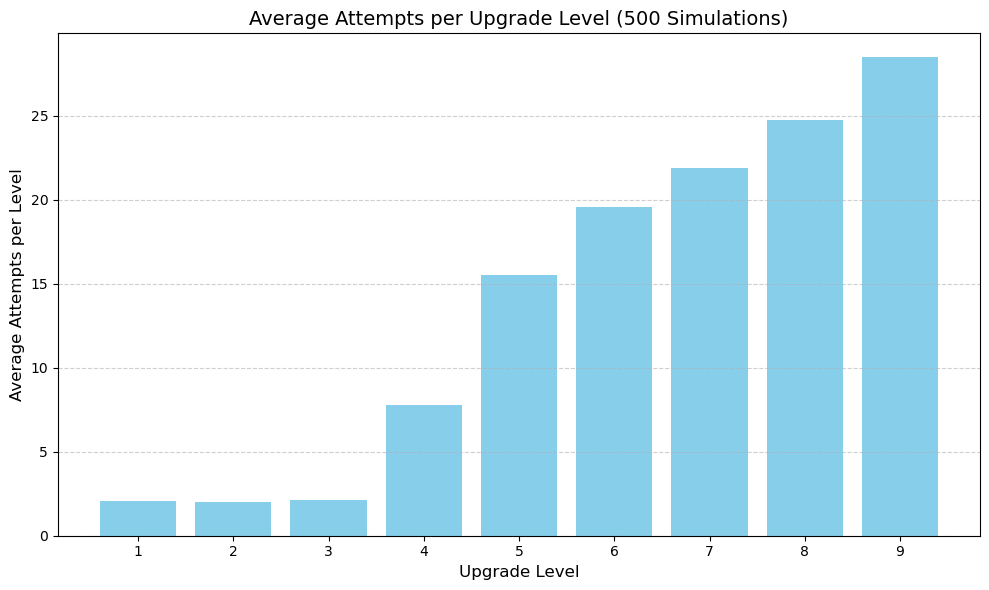

In [30]:
# ===== Graph =====
plt.figure(figsize=(10, 6))
plt.bar(df_level["Upgrade_Level"], df_level["Avg_Attempts"], color='skyblue')
plt.xlabel("Upgrade Level", fontsize=12)
plt.ylabel("Average Attempts per Level", fontsize=12)
plt.title(f"Average Attempts per Upgrade Level ({n_simulations} Simulations)", fontsize=14)
plt.xticks(range(1, max_level + 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

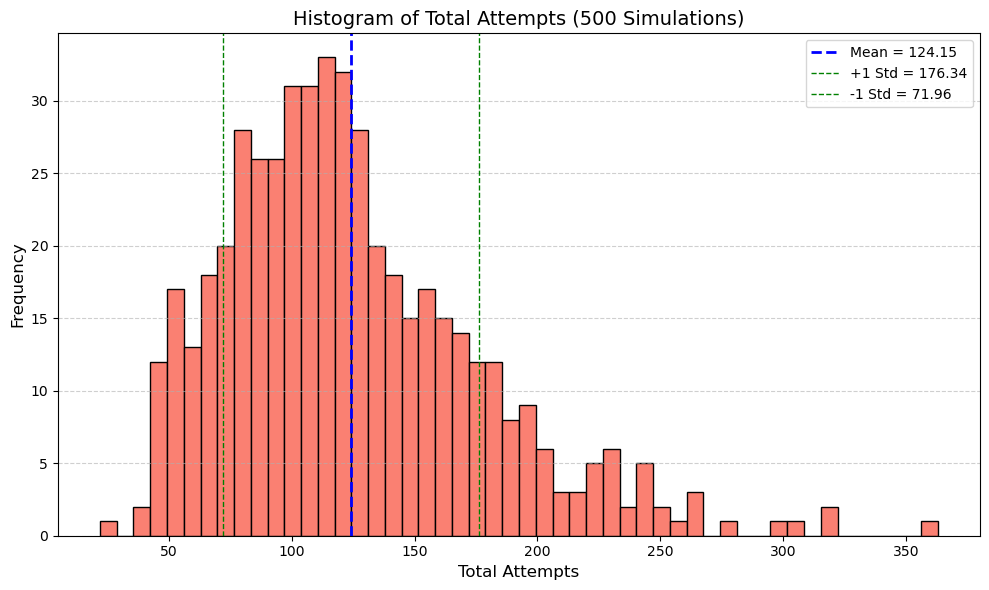

In [36]:
# ===== Histogram of Total Attempts =====
plt.figure(figsize=(10, 6))
plt.hist(df_result["Total_Attempts"], bins=50, color='salmon', edgecolor='black')

# Optional: add mean and std lines
mean_attempts = df_result["Total_Attempts"].mean()
std_attempts = df_result["Total_Attempts"].std()
plt.axvline(mean_attempts, color='blue', linestyle='dashed', linewidth=2, label=f"Mean = {mean_attempts:.2f}")
plt.axvline(mean_attempts + std_attempts, color='green', linestyle='dashed', linewidth=1, label=f"+1 Std = {mean_attempts + std_attempts:.2f}")
plt.axvline(mean_attempts - std_attempts, color='green', linestyle='dashed', linewidth=1, label=f"-1 Std = {mean_attempts - std_attempts:.2f}")

plt.xlabel("Total Attempts", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title(f"Histogram of Total Attempts ({n_simulations} Simulations)", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [37]:
import numpy as np
from scipy.stats import shapiro

# ===== Remove Outliers using IQR =====
data = df_result["Total_Attempts"].copy()
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

print(f"Original data count: {len(data)}, After removing outliers: {len(filtered_data)}")

# ===== Shapiro-Wilk Test for Normality (filtered) =====
stat, p_value = shapiro(filtered_data)
print("\nShapiro-Wilk Test for Normality (Outliers Removed):")
print(f"  Statistic={stat:.4f}, p-value={p_value:.4f}")
if p_value > 0.05:
    print("  -> Data appears to be normally distributed (fail to reject H0)")
else:
    print("  -> Data does NOT appear to be normally distributed (reject H0)")

# ===== 95% Confidence Interval (filtered) =====
mean_attempts_filtered = filtered_data.mean()
std_attempts_filtered = filtered_data.std()
n_filtered = len(filtered_data)
ci_lower = mean_attempts_filtered - 1.96 * (std_attempts_filtered / np.sqrt(n_filtered))
ci_upper = mean_attempts_filtered + 1.96 * (std_attempts_filtered / np.sqrt(n_filtered))
print(f"\n95% Confidence Interval for Mean Total Attempts (Outliers Removed): ({ci_lower:.2f}, {ci_upper:.2f})")

Original data count: 500, After removing outliers: 489

Shapiro-Wilk Test for Normality (Outliers Removed):
  Statistic=0.9703, p-value=0.0000
  -> Data does NOT appear to be normally distributed (reject H0)

95% Confidence Interval for Mean Total Attempts (Outliers Removed): (116.35, 124.54)


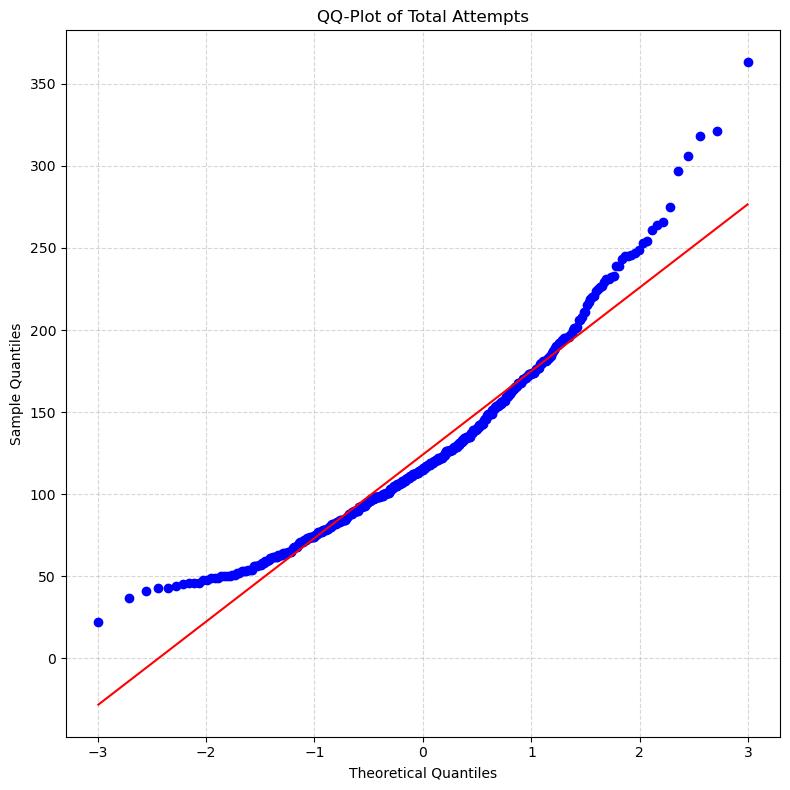

In [38]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# ===== QQ-Plot for Total Attempts =====
plt.figure(figsize=(8, 8))
stats.probplot(df_result["Total_Attempts"], dist="norm", plot=plt)
plt.title("QQ-Plot of Total Attempts")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [39]:
# ===== Save results to CSV =====
df_result.to_csv("item_upgrade_simulation_results.csv", index=False)
df_level.to_csv("item_upgrade_level_avg.csv", index=False)

print("\n✅ CSV files saved successfully!")
print(" - item_upgrade_simulation_results.csv (simulation results)")
print(" - item_upgrade_level_avg.csv (average attempts per level)")


✅ CSV files saved successfully!
 - item_upgrade_simulation_results.csv (simulation results)
 - item_upgrade_level_avg.csv (average attempts per level)
